# Moral value assessment in Natural Language



[`MoralStrength`](https://github.com/oaraque/moral-foundations/) is a Python module that allows us to assess moral values using the [MoralStrength lexicon](https://doi.org/10.1016/j.knosys.2019.105184) [1].

To install MoralStrength, we can use pip:

```pip install moralstrength```

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer

from tqdm.notebook import tqdm

import moralstrength
from moralstrength.moralstrength import estimate_morals

# 1. Read dataset

We use the Moral Foundations Twitter Corpus (MFTC) [2], a dataset composed of Twitter messages, manually annotated with moral values.
This dataset contains several categories of data, corresponding to different campaigns or movements:
* Hurricane Sandy
* Baltimore Protest
* All Lives Matter
* **Black Lives Matter (BLM)**
* 2016 Presidential Election

Read the dataset.
This set has been previously **hydrated** from the original Twitter IDs.

In [2]:
df = pd.read_json("BLM.json", orient="records")
df.head(10)

,text,label
0,The courage to be impatient with evil and pati...,fairness
1,#NotAllCops but OMFG already. 😡 Protect and se...,care
2,"stop shaving, it's your manly dignity #blackje...",non-moral
3,ARABS MORTAL HATRED AND ENSLAVEMENT OF THE BLA...,care
4,“@Babbsgirl2: #SheriffDavidClarke is my hero! ...,non-moral
5,"Inciting Racial Fear, Hatred and Violence\n#Bl...",care
6,These killings show: 1.) racism 2.) a desensit...,care
7,Police try kindness #blacklivesmatter http://t...,care
8,@S_T_O_P_TERROR @DailyMirror #BLM GLOBALIST CO...,non-moral
9,@GrooveSDC @CaffeineAndHate #ISaluteWhitePeopl...,fairness


## 2. Extract the Moral Values from natural language

For each document, we want to extract the associated Moral Values.
To do so, we use the `estimate_morals` function:

In [3]:
result = estimate_morals(df["text"], process=True)
result.head(10)

/home/oaraque/human-values-tutorial-ic2s2-2023/MoralValues/.venv/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,care,fairness,loyalty,authority,purity
0,4.000000,7.600000,NaN,NaN,1.857143
1,1.600000,NaN,NaN,4.8,7.750000
2,7.000000,NaN,NaN,NaN,NaN
3,NaN,3.666667,NaN,NaN,NaN
4,NaN,NaN,7.857143,NaN,NaN
5,1.666667,NaN,NaN,NaN,NaN
6,1.666667,4.000000,NaN,NaN,NaN
7,7.000000,NaN,NaN,NaN,NaN
8,NaN,NaN,3.250000,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


MoralStrength assessments are encoded following a Likert scale

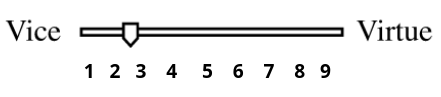

The encoding range is $[1, 9]$, being a value of 5 interpreted as  morally neutral.

We adapt the original scale using the following formula:

$$ e' = |e - 5| $$

For example,
```
The courage to be impatient with evil and patient with people, the courage to fight for social justice. @CornelWest #blacklivesmatter
```
has an associated `Fairness` score of **7.6**. In this case, $e' = 2.6$.

Another example,
```
#CNN #Obama #Aclu #Ap #UN #BlackLivesMatter #Chicago Declare war on these racist delusional Killers Pure Hate and Lies #FBI #DOJ
```
has $e = 1.667$ and $e' = 3.333$

In [8]:
unsup_predictions = np.abs(result - 5).idxmax(axis=1).fillna("non-moral")

Now, we can use the adapted values as relevance for the moral foundation. 
Modelling the task as **presence classification** for each of the moral foundations.

In [9]:
print(
    classification_report(df["label"], unsup_predictions)
)

              precision    recall  f1-score   support

   authority       0.54      0.78      0.63       494
        care       0.65      0.44      0.52      1065
    fairness       0.78      0.61      0.69       940
     loyalty       0.67      0.81      0.73       531
   non-moral       0.56      0.53      0.55      1056
      purity       0.41      0.83      0.55       254

    accuracy                           0.61      4340
   macro avg       0.60      0.67      0.61      4340
weighted avg       0.63      0.61      0.60      4340



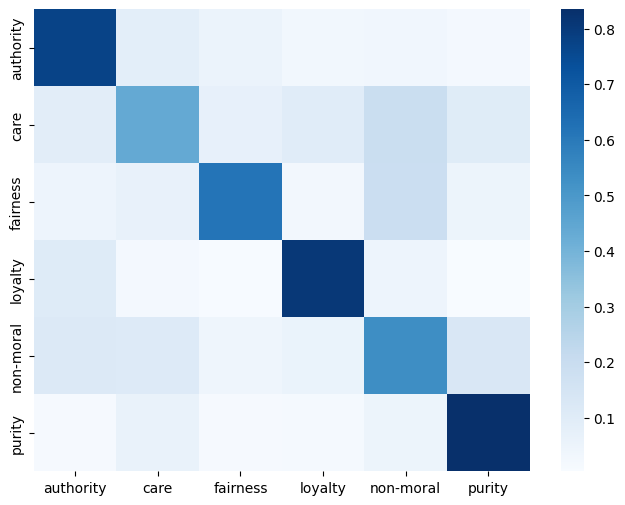

In [10]:
labels = sorted(df["label"].unique())
conf_mat = confusion_matrix(df["label"], unsup_predictions, labels=labels, normalize="true",)
conf_mat = pd.DataFrame(columns=labels, index=labels, data=conf_mat)

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, cmap="Blues")
plt.show()

# 3. Supervised classification of Moral Values

Previously, we have shown how `MoralStrength` allows us to assess morality in natural language in an **unsupervised manner**.

Now, we show how we can use these assessments to enrich text representations in supervised settings.

## 3.1 Pre-process text (simple)

In [11]:
texts_preprocessed = list()
for text in tqdm(moralstrength.nlp_reduced.pipe(df["text"])):
    texts_preprocessed.append(text)

0it [00:00, ?it/s]

/home/oaraque/human-values-tutorial-ic2s2-2023/MoralValues/.venv/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


## 3.2 Extract TF-IDF features

In [12]:
texts = list()
for doc in texts_preprocessed:
    text_i = list()
    for token in doc:
        text_i.append(token.lemma_)
    texts.append(" ".join(text_i))

In [13]:
unigram = CountVectorizer(max_features=10000)
unigram_features = unigram.fit_transform(texts)
unigram_features

<4340x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 54578 stored elements in Compressed Sparse Row format>

## 3.3 Evaluate the classifier

In [14]:
def get_classifier():
    return SGDClassifier(loss="hinge", random_state=42)

classifier = get_classifier()

sup_preds = cross_val_predict(
    classifier,
    unigram_features,
    df["label"],
    cv=10,
    n_jobs=-1
)

assert sup_preds.shape[0] == df["label"].shape[0]

In [15]:
print(
    classification_report(df["label"], sup_preds, digits=2)
)

              precision    recall  f1-score   support

   authority       0.83      0.87      0.85       494
        care       0.71      0.72      0.72      1065
    fairness       0.87      0.83      0.85       940
     loyalty       0.90      0.84      0.87       531
   non-moral       0.71      0.76      0.73      1056
      purity       0.85      0.74      0.79       254

    accuracy                           0.79      4340
   macro avg       0.81      0.79      0.80      4340
weighted avg       0.79      0.79      0.79      4340



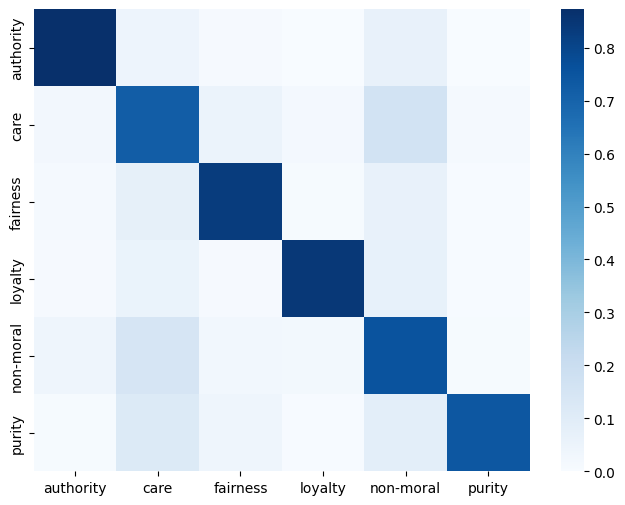

In [16]:
labels = sorted(df["label"].unique())
conf_mat = confusion_matrix(df["label"], sup_preds, labels=labels, normalize="true",)
conf_mat = pd.DataFrame(columns=labels, index=labels, data=conf_mat)

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, cmap="Blues")
plt.show()

The defined learning model is as follows:

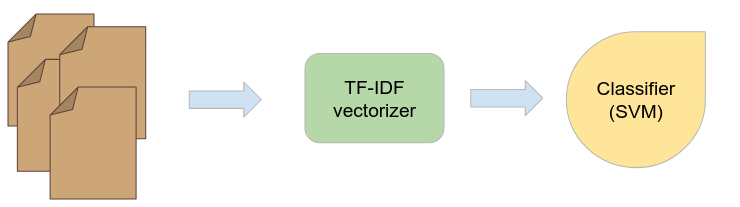

It uses just **one mode** of information.

Now, let's evaluate a more complete model, combining the textual model with the extracted moral values

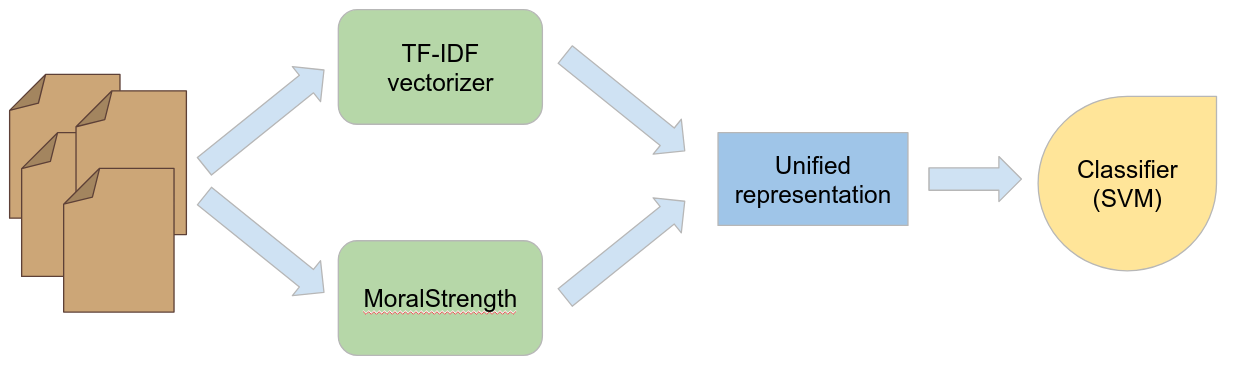

## 3.4 Including information from MoralStrength

In [17]:
moralstrength_features = minmax_scale((result.fillna(5.0) - 5).values)

combined_features = hstack([unigram_features, moralstrength_features])
combined_features

<4340x10005 sparse matrix of type '<class 'numpy.float64'>'
	with 76246 stored elements in COOrdinate format>

## 3.5 Evaluate the combined classifier

In [18]:
classifier = get_classifier()

sup_preds = cross_val_predict(
    classifier,
    combined_features,
    df["label"], cv=10, n_jobs=-1
)

assert sup_preds.shape[0] == df["label"].shape[0]

In [19]:
print(
    classification_report(df["label"], sup_preds, digits=2)
)

              precision    recall  f1-score   support

   authority       0.83      0.88      0.86       494
        care       0.73      0.73      0.73      1065
    fairness       0.87      0.84      0.86       940
     loyalty       0.92      0.84      0.88       531
   non-moral       0.71      0.77      0.74      1056
      purity       0.85      0.74      0.79       254

    accuracy                           0.80      4340
   macro avg       0.82      0.80      0.81      4340
weighted avg       0.80      0.80      0.80      4340



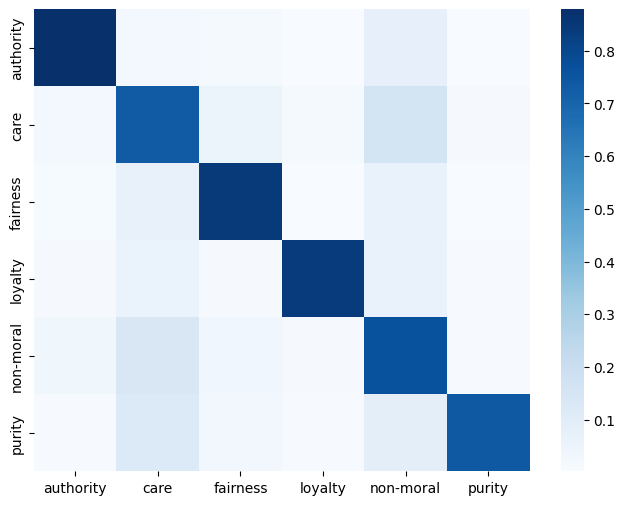

In [20]:
labels = sorted(df["label"].unique())
conf_mat = confusion_matrix(df["label"], sup_preds, labels=labels, normalize="true",)
conf_mat = pd.DataFrame(columns=labels, index=labels, data=conf_mat)

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, cmap="Blues")
plt.show()

# References

[1] Oscar Araque, Lorenzo Gatti, Kyriaki Kalimeri, MoralStrength: Exploiting a moral lexicon and embedding similarity for moral foundations prediction, Knowledge-Based Systems, Volume 191, 2020, 105184, ISSN 0950-7051, https://doi.org/10.1016/j.knosys.2019.105184.


[2] Hoover, J., Portillo-Wightman, G., Yeh, L., Havaldar, S., Davani, A. M., Lin, Y., ... & Dehghani, M. (2020). Moral foundations twitter corpus: A collection of 35k tweets annotated for moral sentiment. Social Psychological and Personality Science, 11(8), 1057-1071.